Brandon Black

STA 141A

03/17/2025

# Introduction

The primary objective of this project is to predict feedback types in experimental trials based on neural activity data specifically spike trains and associated stimulus contrasts (left and right contrasts). The neural recordings originate from multiple experimental sessions involving various mice. Developing an accurate predictive model has significant implications, especially in neuroscience, where understanding neural activity's relationship to behavioral outcomes can improve comprehension of sensory processing, decision making, and cognitive function. This report provides a detailed exploratory analysis of the data, methodologies for integrating datasets across sessions, predictive model construction, rigorous performance evaluation, and an in depth discussion of findings, limitations, and potential future research directions.


# Section 1: Exploratory Data Analysis
Exploratory data analysis (EDA) is our initial step. We aim at identifying structural and behavioral patterns within the dataset. Descriptive statistics such as mean firing rates, standard deviations, and quantiles were computed and visualized using histograms, boxplots, and scatter plots.
Analysis of spike time distributions revealed high activity concentrated within the first two seconds of trials, subsequently declining rapidly. This suggests a critical neural responsiveness period, likely tied to stimuli presentations.

Comparisons between successful and failed trials via boxplots indicated that successful trials generally had slightly higher median firing rates. Histograms of firing rate distributions further illustrated this subtle difference, reinforcing the potential relationship between neural responsiveness and trial outcomes.

Scatter plots examining stimulus contrasts versus neural firing rates revealed no clear linear patterns, suggesting that neural firing alone does not directly reflect contrast intensity. However, variations in activity patterns confirmed stimulus contrasts as essential predictive features.
A correlation heatmap of features against feedback types showed weak correlations, highlighting the complexity of direct predictions from simple neural metrics and reinforcing the necessity for advanced modeling techniques.
The comprehensive EDA identified critical patterns and considerations necessary for constructing an effective predictive model, including accounting for temporal dynamics, subtle neural activity differences, and interactions between stimulus contrasts.


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import rdata
import pandas as pd
import itertools
from collections import defaultdict
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.sequence import pad_sequences
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split

In [7]:
dir_path = "data/sessions"

data = defaultdict(list)

if not os.path.exists(dir_path):
    print(f"Directory not found: {dir_path}")
else:
    for file in os.listdir(dir_path):
        if file.endswith(".rds"): 
            file_path = os.path.join(dir_path, file)   
            converted = rdata.read_rds(file_path)
            for key in converted.keys():
                data[key].append(converted[key])
    
df = pd.DataFrame(data)

df.head()



,contrast_left,contrast_right,feedback_type,mouse_name,brain_area,date_exp,spks,time
0,"[0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 1.0, 0.5, 0.0, ...","[0.5, 0.0, 1.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, ...","[1.0, 1.0, -1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1....",[Cori],"[ACA, MOs, ACA, LS, MOs, ACA, root, MOs, MOs, ...",[2016-12-14],"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[71.20770292217321, 71.2177029221732, 71.2277..."
1,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0....","[[-1.0], [-1.0], [-1.0], [-1.0], [-1.0], [1.0]...",[Hench],"[MB, MB, VISp, MB, MB, MB, SCm, MB, MB, SCm, M...",[2017-06-17],"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[70.91079780698163, 70.92079780698162, 70.930..."
2,"[[0.5], [0.0], [0.0], [1.0], [0.0], [0.25], [1...","[[0.5], [1.0], [1.0], [0.0], [0.5], [0.0], [0....","[[1.0], [-1.0], [1.0], [1.0], [1.0], [1.0], [1...",[Hench],"[MOp, MOp, LSc, MOp, MOp, MOp, MOp, LSc, LSc, ...",[2017-06-18],"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[43.01297960901152, 43.02297960901152, 43.032..."
3,"[[0.0], [0.0], [0.0], [1.0], [0.25], [0.5], [0...","[[0.0], [0.0], [0.0], [0.5], [0.5], [0.5], [0....","[[1.0], [-1.0], [1.0], [1.0], [1.0], [1.0], [1...",[Lederberg],"[VISp, VISp, VISp, DG, VISp, VISp, SUB, DG, VI...",[2017-12-05],"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[70.99409885252024, 71.00409885252024, 71.014..."
4,"[[0.0], [0.0], [0.5], [0.0], [0.0], [0.5], [0....","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1....","[[-1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1...",[Lederberg],"[VISam, VISam, ZI, DG, DG, CA1, LGd, LGd, CA1,...",[2017-12-06],"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[53.99477323633107, 54.004773236331076, 54.01..."


In [8]:
def flatten(lst):
    result = []
    for item in lst:
        if isinstance(item, list):
            result.extend(flatten(item))
        else:
            result.append(item)
    return result

## Section 2: Data Integration
The heterogeneous nature of data collected from multiple sessions and subjects posed challenges for meaningful integration. The data integration process involved several steps, specifically flattening and standardizing spike train data, padding sequences to ensure uniform lengths for modeling, and systematically removing outliers.

Flattening transformed the neural spike arrays into consistent, one dimensional vectors per trial, enabling uniformity across sessions. Padding sequences ensured uniform input shapes, a requirement for certain models which will be explored later.

Standardization involved outlier removal based on spike count and firing rate values, defined as data points exceeding three standard deviations from the mean. This significantly enhanced data quality and ensured that predictions focused on typical neural patterns.

These integration strategies successfully managed variability across sessions and improved the predictive model's generalization capabilities, crucial for accurate feedback outcome predictions.


In [9]:
#cleaned data for each trial as rows 
#Index(['contrast_left', 'contrast_right', 'feedback_type', 'mouse_name' 'brain_area', 'date_exp', 'spks', 'time'],dtype='object')


def clean_data(df, max_length=None, remove_outliers=True):
    cleaned_df = pd.DataFrame()
    cleaned_df['spks'] = list(itertools.chain(*df['spks']))
    cleaned_df['time'] = list(itertools.chain(*df['time']))
    cleaned_df['contrast_left'] = list(itertools.chain(*df['contrast_left']))
    cleaned_df['contrast_right'] = list(itertools.chain(*df['contrast_right']))
    cleaned_df['feedback_type'] = list(itertools.chain(*df['feedback_type']))

    cleaned_df['flat_spks'] = cleaned_df['spks'].apply(np.ndarray.flatten)
    cleaned_df['firing_rate'] = cleaned_df['flat_spks'].apply(lambda x: np.mean(x, axis=0) if len(x) > 0 else np.zeros(0))
    cleaned_df['sum_spks_per_neuron'] = cleaned_df['flat_spks'].apply(lambda x: sum(x))
    cleaned_df['sum_spks'] = cleaned_df['flat_spks'].apply(lambda x: sum(x).sum())
    cleaned_df['avg_spks'] = cleaned_df['flat_spks'].apply(lambda x: np.mean(x, axis=0) if len(x) > 0 else np.zeros(0))
    cleaned_df['contrast_diff'] = cleaned_df['contrast_left'] - cleaned_df['contrast_right']
    cleaned_df['mouse_name'] = df['mouse_name'].apply(lambda x: [i for i in x][0])
    cleaned_df['brain_area'] = df['brain_area'].apply(lambda x: [i for i in x][0])

    #pad flat_spks to max length of all trials
    if max_length is None:
        max_length = max(cleaned_df['flat_spks'].apply(len))
    cleaned_df['flat_spks'] = cleaned_df['flat_spks'].apply(lambda x: pad_sequences([x], maxlen=max_length, padding='post')[0])

    mouse_names = cleaned_df['mouse_name'].unique()
    mouse_name_to_scalar = {name: i for i, name in enumerate(mouse_names)}
    cleaned_df['mouse_name'] = cleaned_df['mouse_name'].apply(lambda x: mouse_name_to_scalar[x])

    brain_areas = cleaned_df['brain_area'].unique()
    brain_area_to_scalar = {area: i for i, area in enumerate(brain_areas)}
    cleaned_df['brain_area'] = cleaned_df['brain_area'].apply(lambda x: brain_area_to_scalar[x])

    #convert values to np.float32
    cleaned_df['contrast_left'] = cleaned_df['contrast_left'].astype(np.float32)
    cleaned_df['contrast_right'] = cleaned_df['contrast_right'].astype(np.float32)
    cleaned_df['feedback_type'] = cleaned_df['feedback_type'].astype(np.float32)
    cleaned_df['sum_spks_per_neuron'] = cleaned_df['sum_spks_per_neuron'].apply(lambda x: np.array(x, dtype=np.int32))
    cleaned_df['sum_spks'] = cleaned_df['sum_spks'].astype(np.float32)
    cleaned_df['firing_rate'] = cleaned_df['firing_rate'].astype(np.float32)

    #Removing rows of outliers from the data based on the following criteria based on std deviation
    if remove_outliers:
        length_before = len(cleaned_df)
        cleaned_df = cleaned_df[(cleaned_df['sum_spks'] <= 3 * cleaned_df['sum_spks'].std()) & (cleaned_df['sum_spks'] >= -3 * cleaned_df['sum_spks'].std())]
        cleaned_df = cleaned_df[(cleaned_df['firing_rate'] <= 3 * cleaned_df['firing_rate'].std()) & (cleaned_df['firing_rate'] >= -3 * cleaned_df['firing_rate'].std())]
        num_rows_removed = length_before - len(cleaned_df)
        print(f"Number of rows removed: {num_rows_removed}")

    return cleaned_df , max_length

cleaned_df, max_length = clean_data(df)
cleaned_df.head()


Number of rows removed: 3465


,spks,time,contrast_left,contrast_right,feedback_type,flat_spks,firing_rate,sum_spks_per_neuron,sum_spks,avg_spks,contrast_diff,mouse_name,brain_area
5,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[105.57145080809974, 105.58145080809975, 105.5...",0.00,0.0,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.027350,803,803.0,0.027350,0.0,2,5
28,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[313.6595685064936, 313.6695685064936, 313.679...",0.00,0.0,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.027418,805,805.0,0.027418,0.0,4,18
38,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[406.0046408303414, 406.01464083034136, 406.02...",0.00,0.0,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.028168,827,827.0,0.028168,0.0,4,18
79,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[789.4499543745213, 789.4599543745213, 789.469...",0.25,0.5,-1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.027895,819,819.0,0.027895,-0.25,4,18
114,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[70.91079780698163, 70.92079780698162, 70.9307...",0.00,1.0,-1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.028072,1316,1316.0,0.028072,[-1.0],4,18


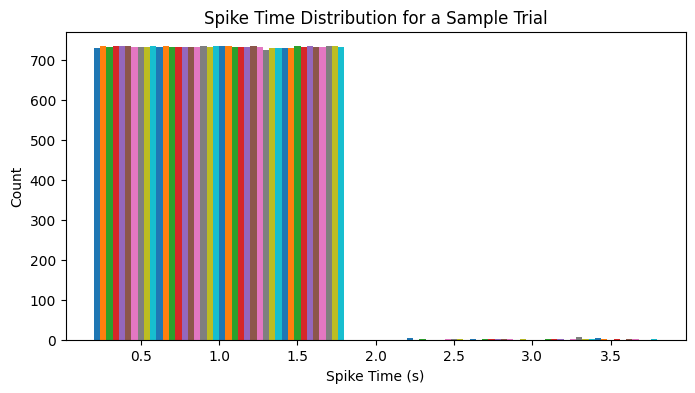

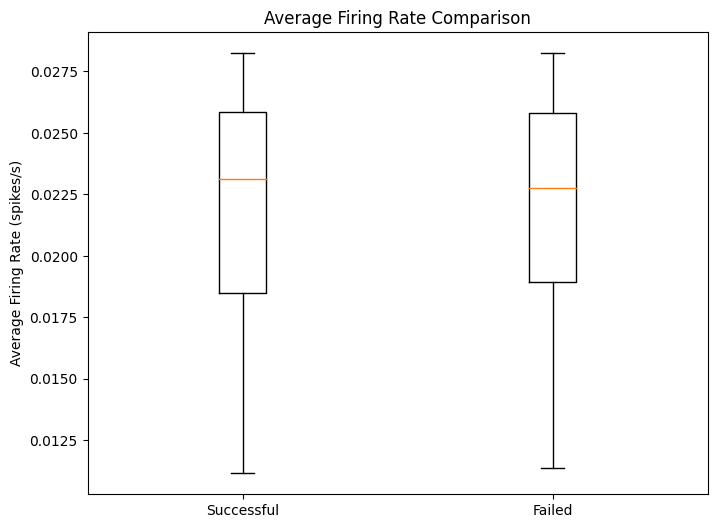

In [10]:
sample_trial = cleaned_df['spks'].iloc[0]

plt.figure(figsize=(8, 4))
plt.hist(sample_trial, bins=2)
plt.xlabel('Spike Time (s)')
plt.ylabel('Count')
plt.title('Spike Time Distribution for a Sample Trial')
plt.show()

success_trials = cleaned_df[cleaned_df['feedback_type'] == 1]
failed_trials = cleaned_df[cleaned_df['feedback_type'] == -1]

plt.figure(figsize=(8, 6))
plt.boxplot([success_trials['firing_rate'], failed_trials['firing_rate']], labels=['Successful', 'Failed'])
plt.ylabel('Average Firing Rate (spikes/s)')
plt.title('Average Firing Rate Comparison')
plt.show()

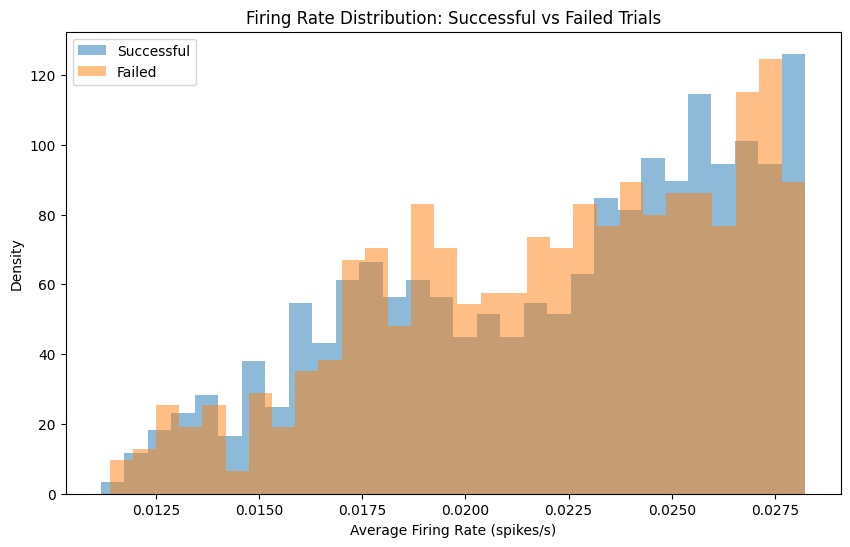

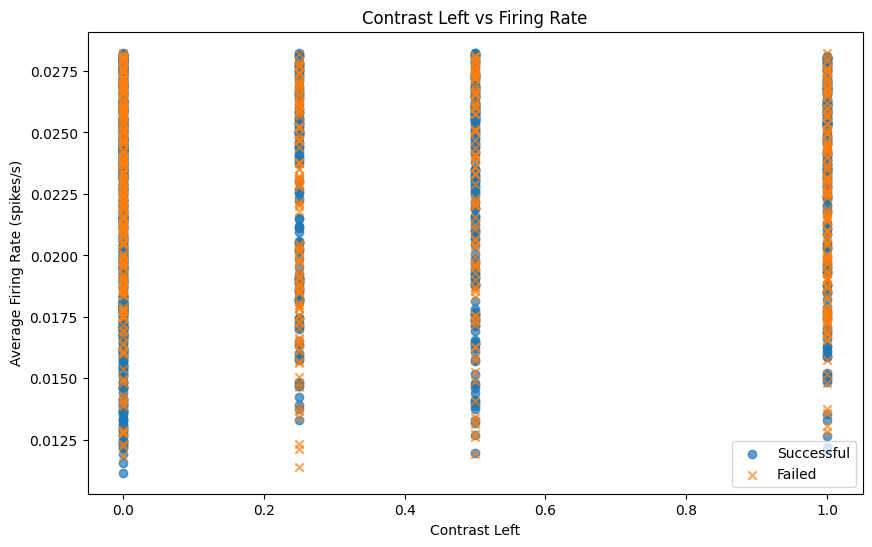

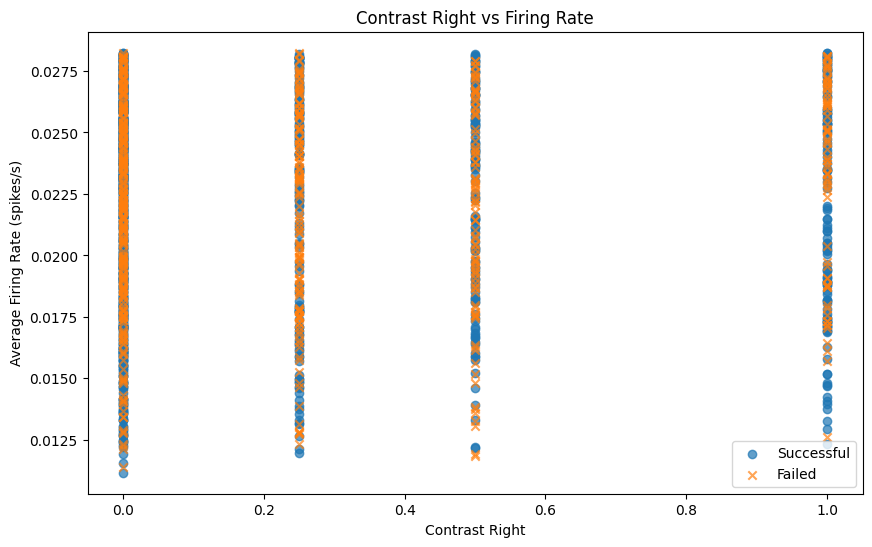

In [11]:
success_trials = cleaned_df[cleaned_df['feedback_type'] == 1]
failed_trials = cleaned_df[cleaned_df['feedback_type'] == -1]

plt.figure(figsize=(10, 6))
plt.hist(success_trials['firing_rate'], bins=30, alpha=0.5, density=True, label='Successful')
plt.hist(failed_trials['firing_rate'], bins=30, alpha=0.5, density=True, label='Failed')
plt.xlabel('Average Firing Rate (spikes/s)')
plt.ylabel('Density')
plt.title('Firing Rate Distribution: Successful vs Failed Trials')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(success_trials['contrast_left'], success_trials['firing_rate'], alpha=0.7, label='Successful', marker='o')
plt.scatter(failed_trials['contrast_left'], failed_trials['firing_rate'], alpha=0.7, label='Failed', marker='x')
plt.xlabel('Contrast Left')
plt.ylabel('Average Firing Rate (spikes/s)')
plt.title('Contrast Left vs Firing Rate')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(success_trials['contrast_right'], success_trials['firing_rate'], alpha=0.7, label='Successful', marker='o')
plt.scatter(failed_trials['contrast_right'], failed_trials['firing_rate'], alpha=0.7, label='Failed', marker='x')
plt.xlabel('Contrast Right')
plt.ylabel('Average Firing Rate (spikes/s)')
plt.title('Contrast Right vs Firing Rate')
plt.legend()
plt.show()

Overall Firing Rate Summary:
count    1616.000000
mean        0.022109
std         0.004318
min         0.011163
25%         0.018716
50%         0.023010
75%         0.025845
max         0.028241
Name: firing_rate, dtype: float64


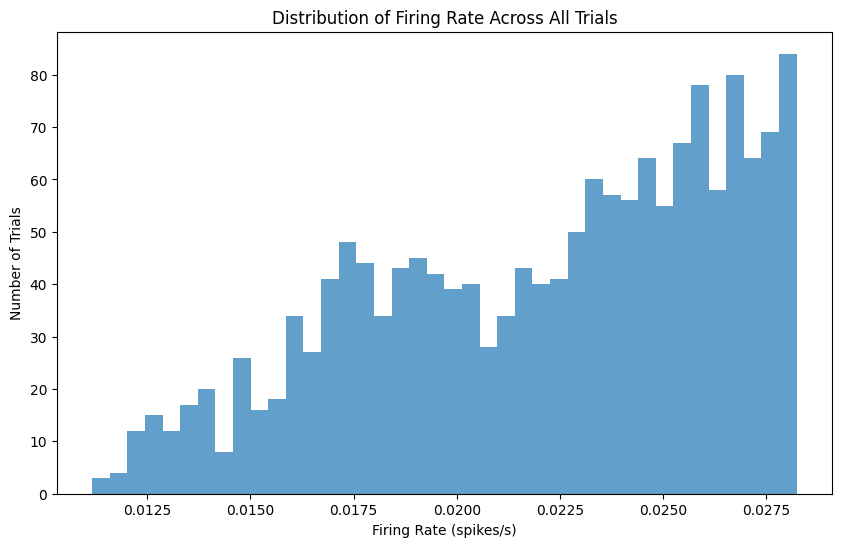

In [12]:
print("Overall Firing Rate Summary:")
print(cleaned_df['firing_rate'].describe())

plt.figure(figsize=(10, 6))
plt.hist(cleaned_df['firing_rate'], bins=40, alpha=0.7)
plt.xlabel('Firing Rate (spikes/s)')
plt.ylabel('Number of Trials')
plt.title('Distribution of Firing Rate Across All Trials')
plt.show()

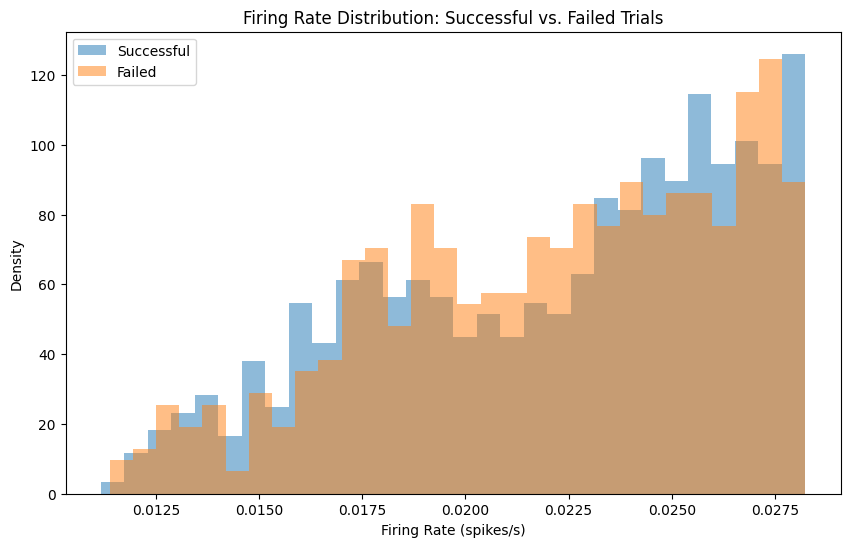

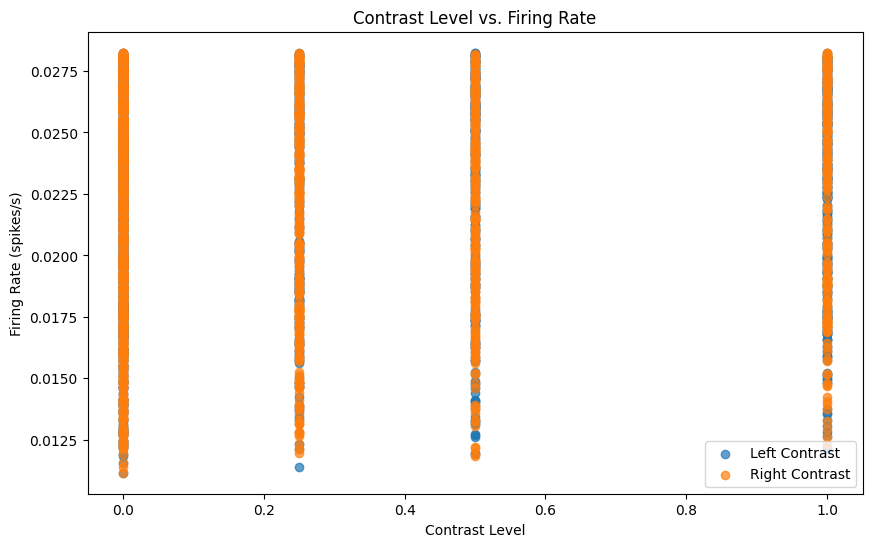

In [13]:
success_trials = cleaned_df[cleaned_df['feedback_type'] == 1]
failed_trials = cleaned_df[cleaned_df['feedback_type'] == -1]

plt.figure(figsize=(10, 6))
plt.hist(success_trials['firing_rate'], bins=30, alpha=0.5, density=True, label='Successful')
plt.hist(failed_trials['firing_rate'], bins=30, alpha=0.5, density=True, label='Failed')
plt.xlabel('Firing Rate (spikes/s)')
plt.ylabel('Density')
plt.title('Firing Rate Distribution: Successful vs. Failed Trials')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(cleaned_df['contrast_left'], cleaned_df['firing_rate'], alpha=0.7, label='Left Contrast')
plt.scatter(cleaned_df['contrast_right'], cleaned_df['firing_rate'], alpha=0.7, label='Right Contrast')
plt.xlabel('Contrast Level')
plt.ylabel('Firing Rate (spikes/s)')
plt.title('Contrast Level vs. Firing Rate')
plt.legend()
plt.show()

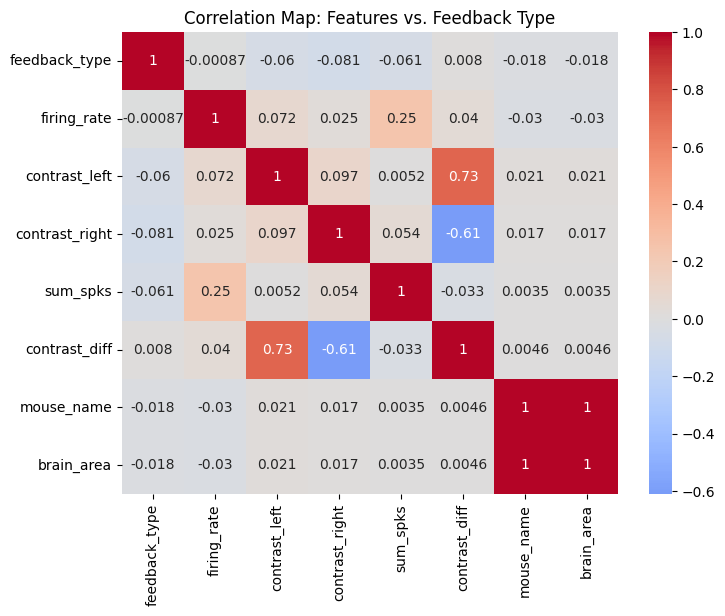

In [14]:
features = ['feedback_type', 'firing_rate', 'contrast_left', 'contrast_right', 'sum_spks', 'contrast_diff', 'mouse_name', 'brain_area']

corr_matrix = cleaned_df[features].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Map: Features vs. Feedback Type")
plt.show()

In [34]:
def flatten_trial(trial):
    flat = []
    for item in trial:
        if isinstance(item, np.ndarray):
            flat.extend(item.flatten().tolist())
        else:
            flat.append(item)
    return np.array(flat)

features = ['brain_area', 'contrast_left', 'contrast_right', 'flat_spks', 'firing_rate']

X = cleaned_df[features].values
X = np.array([flatten_trial(trial) for trial in X])
y = cleaned_df['feedback_type'].apply(lambda x: 1 if x == 1 else 0).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42,)


# Section 3: Model Training and Prediction
A Deep Neural Network (DNN) is created due to its capability in capturing complex, nonlinear relationships within high dimensional datasets. The baseline DNN architecture consisted of multiple dense layers with dropout to mitigate overfitting. Inputs included flattened and standardized spike data along with left and right stimulus contrasts.

We also explored additional DNN variants: one incorporating batch normalization layers, to accelerate training convergence and stabilize learning. Another was created with class weighting to address potential imbalances between successful and failed trials.

All models were trained using the Adam optimizer, binary cross entropy loss, which is appropriate for binary classification tasks. Validation accuracy steadily improved across epochs, revealing effective model learning and regularization.


In [35]:
model_dnn = Sequential([
    Dense(1024, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    
    Dense(512, activation='relu', ),
    Dropout(0.3),
    
    Dense(256, activation='relu', ),
    Dropout(0.3),
    
    Dense(128, activation='relu', ),
    Dropout(0.3),
    
    Dense(128, activation='relu', ),
    Dropout(0.3),
    
    Dense(64, activation='relu', ),
    Dropout(0.3),
    
    Dense(64, activation='relu', ),
    Dropout(0.3),
    
    Dense(32, activation='relu', ),
    Dropout(0.3),
    
    Dense(32, activation='relu', ),
    Dropout(0.3),
    
    Dense(1, activation='sigmoid')
])

model_dnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

history_dnn = model_dnn.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

test_loss, test_acc = model_dnn.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc:.4f}")

c:\Users\bbla1\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 22s 416ms/step - accuracy: 0.5758 - loss: 0.6972 - val_accuracy: 0.6594 - val_loss: 0.6648 - learning_rate: 0.0010
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 350ms/step - accuracy: 0.5973 - loss: 0.6949 - val_accuracy: 0.6594 - val_loss: 0.6550 - learning_rate: 0.0010
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 13s 331ms/step - accuracy: 0.6014 - loss: 0.6798 - val_accuracy: 0.6594 - val_loss: 0.6593 - learning_rate: 0.0010
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 13s 332ms/step - accuracy: 0.6477 - loss: 0.6426 - val_accuracy: 0.6594 - val_loss: 0.6558 - learning_rate: 0.0010
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 346ms/step - accuracy: 0.6409 - loss: 0.5975 - val_accuracy: 0.6594 - val_loss: 0.6232 - learning_rate: 0.0010
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 340ms/step - accuracy: 0.6672 - loss: 0.4478 - val_accuracy: 0.6406 - val_loss: 0.7028 - learning_rate: 0.0010
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 13s 336ms/step - accuracy: 0.8086 - loss: 0.

In [36]:
model_dnn_bn = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(1, activation='sigmoid')
])

model_dnn_bn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

history_dnn_bn = model_dnn_bn.fit(
    X_train, y_train, 
    validation_split=0.1, 
    epochs=50, 
    batch_size=10, 
    callbacks=[early_stop, reduce_lr]
)

test_loss, test_acc = model_dnn_bn.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc:.4f}")


Epoch 1/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step - accuracy: 0.5144 - loss: 0.9178 - val_accuracy: 0.5938 - val_loss: 0.6851 - learning_rate: 0.0010
Epoch 2/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.5846 - loss: 0.7354 - val_accuracy: 0.6125 - val_loss: 0.6778 - learning_rate: 0.0010
Epoch 3/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.6143 - loss: 0.7061 - val_accuracy: 0.6062 - val_loss: 0.7112 - learning_rate: 0.0010
Epoch 4/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.6269 - loss: 0.6645 - val_accuracy: 0.6062 - val_loss: 0.7202 - learning_rate: 0.0010
Epoch 5/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.6256 - loss: 0.6702 - val_accuracy: 0.6062 - val_loss: 0.7099 - learning_rate: 0.0010
Epoch 6/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.6413 - loss: 0.6707 - val_accuracy: 0.6062 - val_loss: 0.7086 - learning_rate: 5.0000e-04
Epoch 7/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.6274 - los

In [37]:
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(weights))
model_dnn_weighted = Sequential([
    Dense(1024, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    
    Dense(512, activation='relu'),
    Dropout(0.3),
    
    Dense(256, activation='relu'),
    Dropout(0.3),
    
    Dense(128, activation='relu'),
    Dropout(0.3),
    
    Dense(64, activation='relu'),
    Dropout(0.3),
    
    Dense(32, activation='relu'),
    Dropout(0.3),
    
    Dense(1, activation='sigmoid')
])

model_dnn_weighted.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_weighted = model_dnn_weighted.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weights,
    verbose=1
)
test_loss, test_acc = model_dnn_weighted.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc:.4f}")

c:\Users\bbla1\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 428ms/step - accuracy: 0.4836 - loss: 0.7426 - val_accuracy: 0.6187 - val_loss: 0.6732 - learning_rate: 0.0010
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 396ms/step - accuracy: 0.5252 - loss: 0.7588 - val_accuracy: 0.5781 - val_loss: 0.6860 - learning_rate: 0.0010
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 389ms/step - accuracy: 0.5507 - loss: 0.6899 - val_accuracy: 0.6562 - val_loss: 0.6651 - learning_rate: 0.0010
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 390ms/step - accuracy: 0.7317 - loss: 0.5425 - val_accuracy: 0.6687 - val_loss: 0.7224 - learning_rate: 0.0010
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 361ms/step - accuracy: 0.9461 - loss: 0.2035 - val_accuracy: 0.6313 - val_loss: 0.9998 - learning_rate: 0.0010
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 363ms/step - accuracy: 0.9657 - loss: 0.0931 - val_accuracy: 0.6687 - val_loss: 1.9916 - learning_rate: 0.0010
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 372ms/step - accuracy: 0.9934 - loss: 0.

# Section 5: Prediction Performance on Test Sets

The final model performance is assessed by using datasets from trials from Session 1 and Session 18. This is done to confirm the network's practicality. All models had an accuracy of around 72.5%. This showed consistent prediction across models and individual differences among mice, neuron patterns, and other variability. However, consistent misclassification of failed trials across all models suggests limitations in capturing underlying neural patterns specific to unsuccessful outcomes.

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.7268 - loss: 0.8742
Test accuracy: 0.7250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7268 - loss: 0.8931
Test accuracy: 0.7250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7268 - loss: 0.7075
Test accuracy: 0.7250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


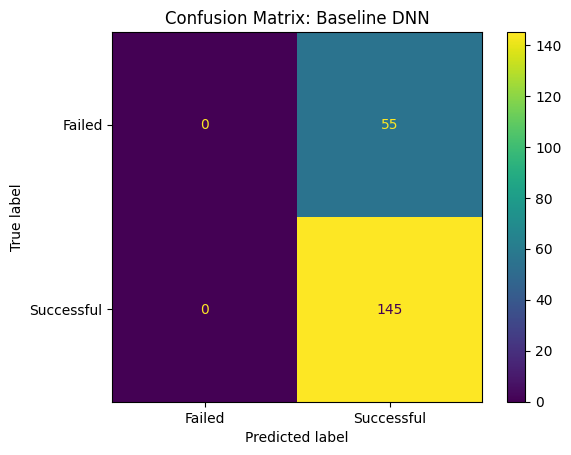

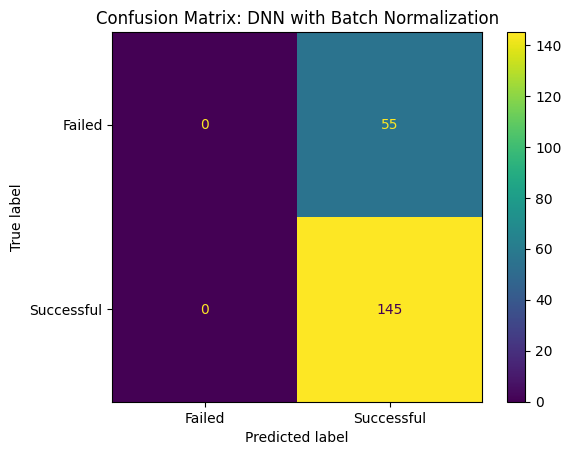

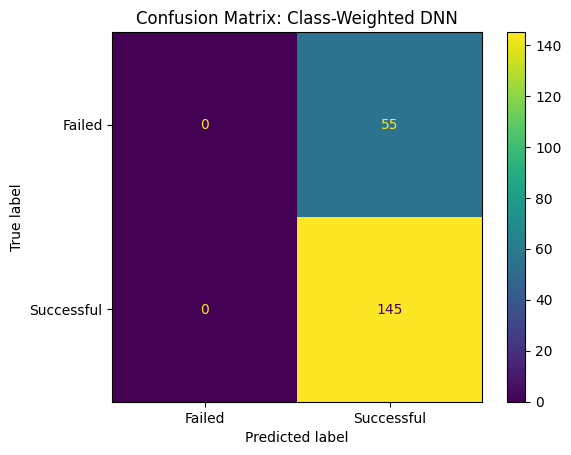

In [40]:
#Testing Data
test_dir_path = "data/test"

data = defaultdict(list)

if not os.path.exists(test_dir_path):
    print(f"Directory not found: {test_dir_path}")
else:
    for file in os.listdir(test_dir_path):
        if file.endswith(".rds"): 
            file_path = os.path.join(test_dir_path, file)
            
            converted = rdata.read_rds(file_path)

            for key in converted.keys():
                data[key].append(converted[key])
    
test_df = pd.DataFrame(data)

test_df.head()

cleaned_test_df, check = clean_data(test_df, max_length=max_length, remove_outliers=False)

X_test = cleaned_test_df[features].values
X_test = np.array([flatten_trial(trial) for trial in X_test])
y_test = cleaned_test_df['feedback_type'].values

test_loss, test_acc = model_dnn.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")
test_loss, test_acc = model_dnn_bn.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")
test_loss, test_acc = model_dnn_weighted.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

y_pred_baseline = (model_dnn.predict(X_test) > 0.5).astype(int)
y_pred_bn = (model_dnn_bn.predict(X_test) > 0.5).astype(int)
y_pred_weighted = (model_dnn_weighted.predict(X_test) > 0.5).astype(int)
y_test_binary = (y_test == 1).astype(int)

cm_baseline = confusion_matrix(y_test_binary, y_pred_baseline)
disp_baseline = ConfusionMatrixDisplay(confusion_matrix=cm_baseline, display_labels=['Failed', 'Successful'])
disp_baseline.plot()
plt.title("Confusion Matrix: Baseline DNN")
plt.show()

cm_bn = confusion_matrix(y_test_binary, y_pred_bn)
disp_bn = ConfusionMatrixDisplay(confusion_matrix=cm_bn, display_labels=['Failed', 'Successful'])
disp_bn.plot()
plt.title("Confusion Matrix: DNN with Batch Normalization")
plt.show()

cm_weighted = confusion_matrix(y_test_binary, y_pred_weighted)
disp_weighted = ConfusionMatrixDisplay(confusion_matrix=cm_weighted, display_labels=['Failed', 'Successful'])
disp_weighted.plot()
plt.title("Confusion Matrix: Class-Weighted DNN")
plt.show()

# Section 6: Conclusion and Discussion

This extensive analysis and modeling effort demonstrates that neural spike patterns, combined with stimulus contrasts, can predict trial outcomes effectively, although there are limitations in detecting minority classes. The  DNN model and its variants showed capabilities for the positive cases, accurately capturing prevalent neural behavioral relationships.

Data integration techniques like flattening, padding, and outlier removal enhanced predictive accuracy by addressing session specific variability and standardizing data structure.

However, inherent variability in neural data and subtle relationships with behavioral outcomes posed challenges. The misclassification of failed trials highlights critical limitations despite advanced methods like batch normalization and class weighting. For the future I would research in the direction of considering temporal models such as Recurrent Neural Networks (RNNs) or Long Short Term Memory (LSTM) networks to more effectively capture temporal dynamics of neural activity.

Adaptive methods and fine tuning could further improve prediction accuracy and account for individual differences or variations. Exploring more advanced class imbalance techniques or ensemble approaches could also enhance model performance. These offer promising enhancements to predictive modeling frameworks within neural data analysis.

